In [1]:
import torch
from PIL import Image
import random
import os
from torchvision import transforms
from timm.data.transforms import str_to_interp_mode
from ..config import _update_config_from_file
import numpy as np

ImportError: attempted relative import with no known parent package

In [2]:
import timm

In [ ]:
# cementation_fissures crack longitudinal_crack loose massive_crack mending normal transverse_crack
class_map = ['cementation_fissures','crack', 'longitudinal_crack', 'loose', 'massive_crack', 'mending', 'normal', 'transverse_crack']
class_name = 'longitudinal_crack'
root_dir = '/data/tangwenhao/cqu_bpdd/1.0.0/train'
_dir = os.path.join(root_dir,class_name)
for root,dirs,files in os.walk(_dir):
    num_pic = len(files)

In [3]:
from config import get_config
config=get_config(None)
_update_config_from_file(config, './configs/rdd_trans.yaml')

=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/rdd_trans.yaml


In [48]:
from models import build_model
model = build_model(config)
cpt = torch.load('/home/tangwenhao/output/swin_multi_view_persudo_clus/model/rdd_trans_swin_small_patch4_window7_224_ema_best_model.pth', map_location='cpu')

In [49]:
ins = {'weight':cpt['state_dict'].pop('instance_feature_extractor.head_instance.weight'),'bias':cpt['state_dict'].pop('instance_feature_extractor.head_instance.bias')}

In [50]:
model.load_state_dict(cpt['state_dict'], strict=False)
model.head_instance.load_state_dict(ins)

<All keys matched successfully>

In [110]:
_file = random.randint(0, num_pic)
img = Image.open(os.path.join(_dir,str(_file)+'.jpg')).convert('RGB')

In [111]:
imgs = transforms.Resize(size=(224,224),interpolation=str_to_interp_mode('bicubic'))(img=img)
imgs = transforms.ToTensor()(imgs)
imgs = transforms.Normalize(mean=torch.tensor((0.485, 0.456, 0.406)),std=torch.tensor((0.229, 0.224, 0.225)))(imgs)
imgs = imgs.unsqueeze(0)

In [112]:
model.eval()
with torch.no_grad():
    _,ins_feat = model.instance_feature_extractor.forward_features(imgs)
    output = model(imgs)
    clusters_idcs,clusters_mask = model.sklearn_cluster(ins_feat)
    _,_,cluster_selected,scores = model.cluster_classifier(ins_feat,None,clusters_idcs,thr=0.99,cluster_num = 3,clusters_mask=clusters_mask)

In [42]:
model.head_instance

Linear(in_features=768, out_features=8, bias=True)

In [47]:
model.head[0]

Linear(in_features=768, out_features=8, bias=True)

In [86]:
cluster_selected

tensor([[False,  True, False]])

In [87]:
scores

tensor([[0.8851, 0.6479, 0.8122]])

In [88]:
clusters_idcs[0]

tensor([1, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1,
        1], device='cuda:0')

In [113]:
softmax=torch.nn.Softmax(-1)
bag_output = softmax(output[0])
inst_output = softmax(output[1])[0]
inst_max_output,inst_max_idic=torch.max(inst_output,dim=-1)

In [114]:
inst_output[:,2]

tensor([0.0799, 0.1216, 0.1577, 0.1756, 0.1493, 0.0775, 0.1594, 0.1741, 0.3664,
        0.5454, 0.5668, 0.5861, 0.1427, 0.1446, 0.2494, 0.4703, 0.4786, 0.5854,
        0.8039, 0.2323, 0.2037, 0.4135, 0.6310, 0.8112, 0.7712, 0.8273, 0.3027,
        0.2160, 0.3357, 0.6232, 0.8152, 0.7704, 0.8150, 0.2989, 0.1781, 0.1786,
        0.3311, 0.5595, 0.5296, 0.5026, 0.1652, 0.1287, 0.2245, 0.4188, 0.4316,
        0.3947, 0.5817, 0.1615, 0.2023])

In [115]:
# 128
from PIL import ImageDraw,ImageFont
img_d = transforms.Resize(size=(896,896),interpolation=str_to_interp_mode('bicubic'))(img=img)
draw = ImageDraw.Draw(img_d)
#font=ImageFont.truetype(size=10)
for i in range(0,len(inst_output)):
    row = int(i / 7)
    col = i % 7
    draw.text((col*128,row*128),class_map[inst_max_idic[i]][:4]+'  '+str(inst_max_output[i].item())[:4]+ '  '+str(clusters_idcs[0][i].item()),fill='red')

In [92]:
bag_output

tensor([[0.0109, 0.0128, 0.4581, 0.0051, 0.0632, 0.0138, 0.3521, 0.0840]])

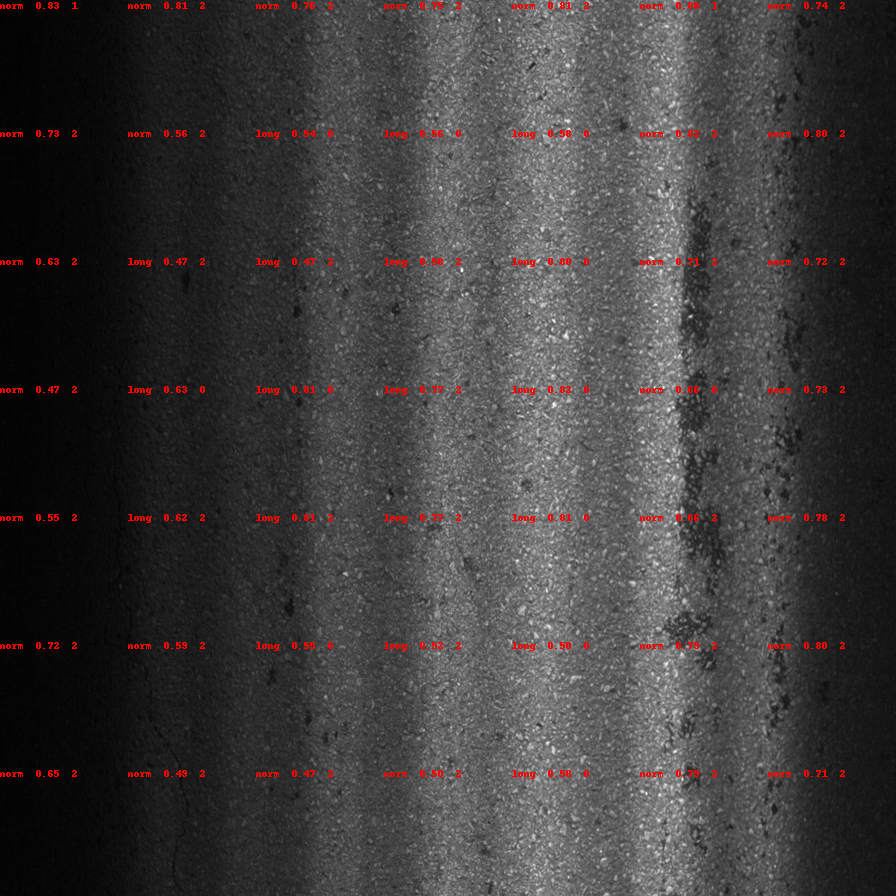

In [116]:
img_d.show()

## CAM

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [26]:
config=get_config(None)
_update_config_from_file(config, '/home/tangwenhao/rdd_code/rdd_transformer/configs/baseline/rdd_swin_small.yaml')
from models import build_model
model_b = build_model(config)
cpt = torch.load('/home/tangwenhao/output/swin/model/swin_small_patch4_window7_224_ema_best_model.pth', map_location='cpu')
model_b.load_state_dict(cpt['state_dict'], strict=False)
_ = model_b.eval()

=> merge config from /home/tangwenhao/rdd_code/rdd_transformer/configs/baseline/rdd_swin_small.yaml


In [10]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [52]:
with torch.no_grad():
    a = model_b(imgs)

In [53]:
softmax(a)

tensor([[2.2458e-04, 3.9289e-06, 9.9653e-01, 1.2876e-05, 2.6556e-03, 4.5395e-05,
         5.1652e-04, 1.5291e-05]])

In [108]:
target_layers = [model.instance_feature_extractor.layers[-1].blocks[-1].norm1]

In [121]:
target_layers = [model_b.layers[-1].blocks[-1].norm1]

In [122]:
cam = GradCAM(model=model_b, target_layers=target_layers, reshape_transform=reshape_transform)

In [119]:
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

In [123]:
target_category = [ClassifierOutputTarget(2)]
grayscale_cam = cam(input_tensor=imgs,
                    targets=target_category,)

In [124]:
# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.resize(np.array(img), (224, 224))
rgb_img = np.float32(rgb_img) / 255
cam_image = show_cam_on_image(rgb_img, grayscale_cam,use_rgb=True)

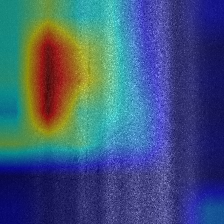

In [112]:
Image.fromarray(cam_image)

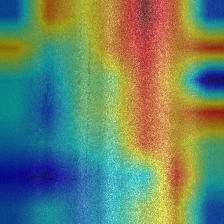

In [125]:
Image.fromarray(cam_image)

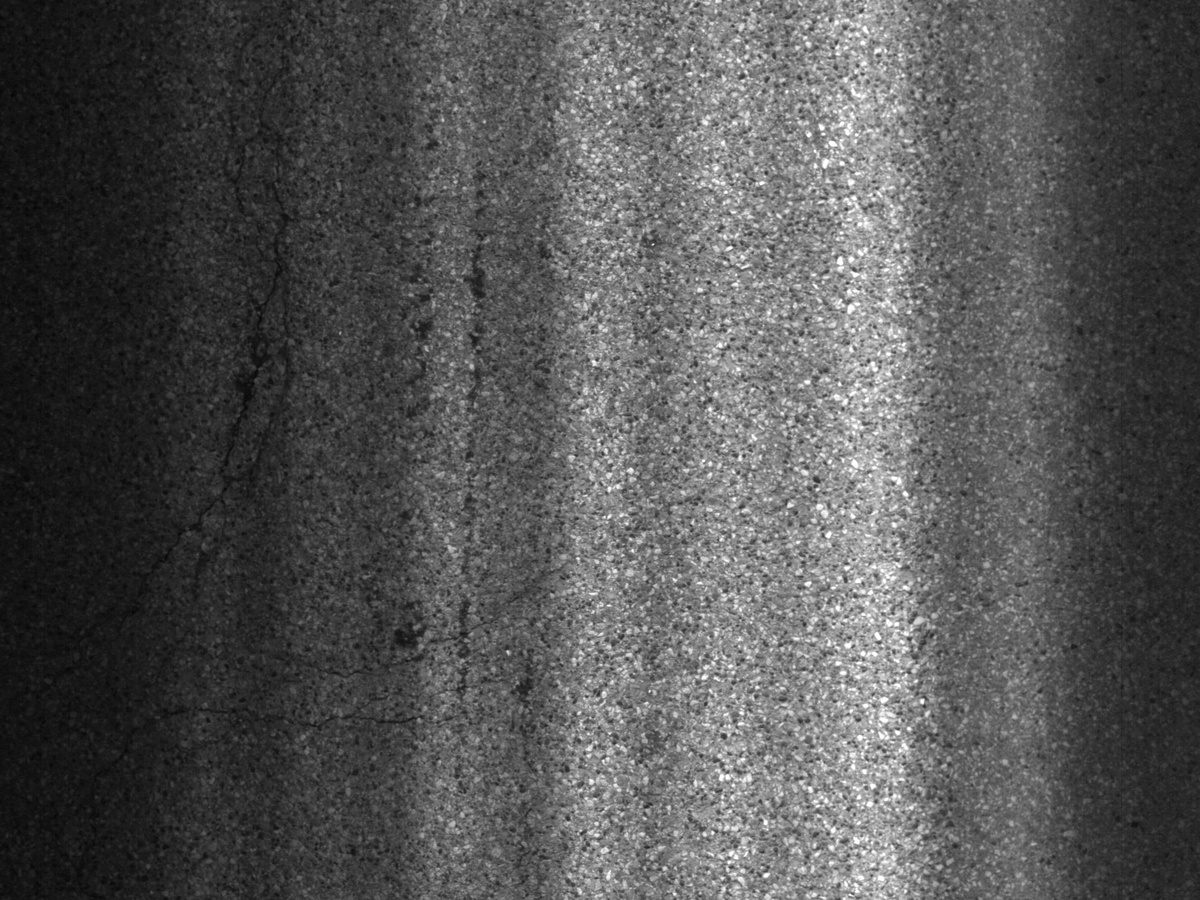

In [113]:
img